In [2]:
import matplotlib as mpl
from scipy.io import netcdf
import matplotlib
#from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import datetime
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import xarray
import metpy.interpolate
#%matplotlib inline

In [3]:
# creates lists for each variable with file names of each 6 hour timestep for specified number of days

dstart = datetime(2015, 1, 1, 0, 0, 0)
ndays = 1096+365 # 4 years including 1 leap year
nfiles = 4
fnameu = []
fnamev = []
fnamephi = []

for t in np.arange(0,ndays):
    
    for i in np.arange(0, nfiles):

        datefmt = '{:%Y%m%dT%H%M}'.format(dstart)
        dateyear = '{:%Y}'.format(dstart)
        dateday = '{:%m}'.format(dstart)
    
        fnameu.append('/g/data/cj37/BARRA/BARRA_R/v1/forecast/prs/wnd_ucmp/'+dateyear+'/'+dateday+'/wnd_ucmp-fc-prs-PT1H-BARRA_R-v1-'+datefmt+'Z.sub.nc')
        fnamev.append('/g/data/cj37/BARRA/BARRA_R/v1/forecast/prs/wnd_vcmp/'+dateyear+'/'+dateday+'/wnd_vcmp-fc-prs-PT1H-BARRA_R-v1-'+datefmt+'Z.sub.nc')
        fnamephi.append('/g/data/cj37/BARRA/BARRA_R/v1/forecast/prs/geop_ht/'+dateyear+'/'+dateday+'/geop_ht-fc-prs-PT1H-BARRA_R-v1-'+datefmt+'Z.sub.nc')

        dstart =  dstart + timedelta(hours=6)
    
    dstart =  dstart + timedelta(hours=0)
    


Coordinate limits:  (14, 28) (12, 37) <br> Coonooer bridge gridpoints: (19, 22)

In [4]:

nt = ndays*24

jstart = 241+12
jend = 241 + 13
istart = 690+28
iend = 690+37
pstart = 32
pend = 37
plevels = pend-pstart

# # Load files from BARRA
# chunks = {'time': 1, 'level': -1}

# #u and v winds
# u = xarray.open_mfdataset(fnameu, chunks = chunks, engine = 'netcdf4').wnd_ucmp[:, pstart:pend,jstart:jend,istart:iend]
# v = xarray.open_mfdataset(fnamev, chunks = chunks, engine = 'netcdf4').wnd_vcmp[:, pstart:pend,jstart:jend,istart:iend]

# #geopotential height
# height = xarray.open_mfdataset(fnamephi, chunks = chunks).geop_ht[:, pstart:pend,jstart:jend,istart:iend]

#topography
topog = xarray.open_dataset('Downloads/topog-an-slv-PT0H-BARRA_R-v1-20150207T0000Z.nc')
topog = topog.topog[jstart:jend,istart:iend]

In [5]:
# test_h = height.compute()
# test_u = u.compute()
# test_v = v.compute()

In [6]:
# height = xarray.DataArray(test_h, name = 'height')
# u = xarray.DataArray(test_u, name = 'u')
# v = xarray.DataArray(test_v, name = 'v')

# height['latitude'] = u['latitude']
# height['longitude'] = u['longitude']

# data = xarray.merge([height,u,v], compat = "override")
# data.to_netcdf('/g/data/v46/lh2344/height_uvwind.nc')

In [7]:
data = xarray.open_dataset('/g/data/v46/lh2344/height_uvwind.nc')

In [33]:
u = data.u[...,0:1,:]
v = data.v[...,0:1,:]
height = data.height[...,0:1,:]

dstart = datetime(2015, 1, 1, 0, 0, 0)
EST = timedelta(hours = 10)
t_EST = np.arange(dstart + EST, dstart + timedelta(hours=nt)+EST, timedelta(hours=1)).astype(datetime)
u['time'] = t_EST
v['time'] = t_EST
height['time'] = t_EST

In [35]:
topog['latitude'] = height['latitude']
topog['longitude'] = height['longitude']

In [36]:
agl = xarray.DataArray(np.empty(height.shape), dims = height.dims)
agl = height-topog

In [37]:
coords_isosurf={
    agl.dims[0]:agl.coords[agl.dims[0]],
    agl.dims[2]:agl.coords[agl.dims[2]],   # latitude name and dimension
    agl.dims[3]:agl.coords[agl.dims[3]]    # longitude name and dimension
}

uwind100 = xarray.DataArray(np.empty([agl.shape[0],agl.shape[2],agl.shape[3]]), 
                            coords = coords_isosurf)
vwind100 = xarray.DataArray(np.empty([agl.shape[0],agl.shape[2],agl.shape[3]]), 
                            coords = coords_isosurf) 

interp_level = 100

for t in np.arange(0,height.shape[0]):
    uwind100[t,...] = metpy.interpolate.interpolate_to_isosurface(agl.data[t,...], u.data[t,...], interp_level)
    vwind100[t,...] = metpy.interpolate.interpolate_to_isosurface(agl.data[t,...], v.data[t,...], interp_level)


In [38]:
from metpy.units import units
speed = metpy.calc.wind_speed(uwind100*units("m/s"), vwind100*units("m/s"))
direction = metpy.calc.wind_direction(uwind100*units("m/s"), vwind100*units("m/s"))

In [39]:
jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnightsv2')
jetnight2 = xarray.DataArray(jetnight.jetnight2_v2, dims = ['time','latitude','longitude'])[...,12:13,28:37]

jetnight_true = jetnight2.sum(dim = ['latitude', 'longitude']) > 1
# On a jetnight an array is created so that every half hour timestep within a jetnight is defined at 'True' and
# 'False' otherwise
jethour_true = np.empty(jetnight2.shape[0]*24)
for day in range(0,jetnight2.shape[0]):
    daystart = day*24
    dayend = (day*24)+24
    for hour in range(daystart,dayend):
        jethour_true[hour] = jetnight_true[day]
jethour_true.sum()

jethour_true = np.array(jethour_true, dtype = bool)
jethour_false = ~jethour_true

In [40]:
jethour_true

array([False, False, False, ...,  True,  True,  True])

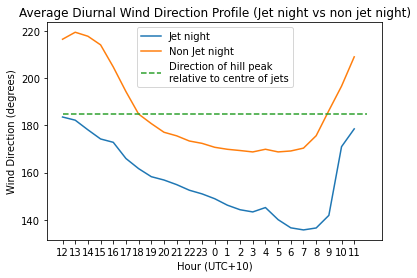

In [41]:
direction_jn = direction[jethour_true,...]
direction_nonjn = direction[~jethour_true,...]

mean_direction_jn = direction_jn.groupby(direction_jn["time"].dt.hour).mean()
mean_hourly_direction_jn = mean_direction_jn.mean(dim = ['latitude','longitude'])

# Rearange hours so all begin at 12pm rather than 12am
hour = np.concatenate([np.arange(12,24), np.arange(0,12)])

reordered = xarray.DataArray(
    [mean_hourly_direction_jn[12:24], mean_hourly_direction_jn[0:12]]).stack(hours = ['dim_0','dim_1'])
reordered_jn = xarray.DataArray(np.array(reordered), coords = {'hour':hour})

mean_direction_nonjn = direction_nonjn.groupby(direction_nonjn["time"].dt.hour).mean()
mean_hourly_direction_nonjn = mean_direction_nonjn.mean(dim = ['latitude','longitude'])

reordered = xarray.DataArray(
    [mean_hourly_direction_nonjn[12:24], mean_hourly_direction_nonjn[0:12]]).stack(hours = ['dim_0','dim_1'])
reordered_nonjn = xarray.DataArray(np.array(reordered), coords = {'hour':hour})

# Direction jet night
plt.plot(reordered_nonjn.hour.astype(str), reordered_jn, label = 'Jet night')
# Direction non jetnight
plt.plot(reordered_nonjn.hour.astype(str), reordered_nonjn, label = 'Non Jet night')
# Constant line showing direction of hills
plt.plot([0,24],[185,185], linestyle = '--', label = 'Direction of hill peak \nrelative to centre of jets')
plt.xlabel('Hour (UTC+10)')
plt.ylabel('Wind Direction (degrees)')
plt.title('Average Diurnal Wind Direction Profile (Jet night vs non jet night)')

plt.legend()
plt.savefig('Diurnal Wind direction profile at peak area')

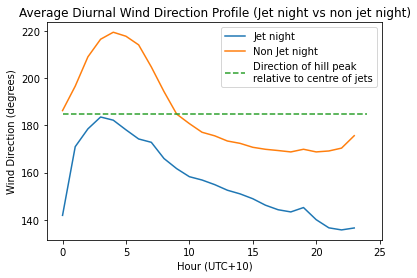

In [26]:
direction_jn = direction[jethour_true,...]
direction_nonjn = direction[~jethour_true,...]

mean_direction_jn = direction_jn.groupby(direction_jn["time"].dt.hour).mean()
mean_hourly_direction_jn = mean_direction_jn.mean(dim = ['latitude','longitude'])

mean_direction_nonjn = direction_nonjn.groupby(direction_nonjn["time"].dt.hour).mean()
mean_hourly_direction_nonjn = mean_direction_nonjn.mean(dim = ['latitude','longitude'])


# Direction jet night
plt.plot(mean_hourly_direction_jn, label = 'Jet night')
# Direction non jetnight
plt.plot(mean_hourly_direction_nonjn, label = 'Non Jet night')
# Constant line showing direction of hills
plt.plot([0,24],[185,185], linestyle = '--', label = 'Direction of hill peak \nrelative to centre of jets')
plt.xlabel('Hour (UTC+10)')
plt.ylabel('Wind Direction (degrees)')
plt.title('Average Diurnal Wind Direction Profile (Jet night vs non jet night)')

plt.legend()

In [20]:
# direction_xarray = xarray.DataArray(np.array(direction), name = "direction", dims = ["pressure", "latitude", "longitude"])
# speed_xarray = xarray.DataArray(np.array(speed), name = "speed", dims = ["pressure", "latitude", "longitude"])
direction1D = np.array(direction).reshape(-1,1).ravel()
speed1D = np.array(speed).reshape(-1,1).ravel()

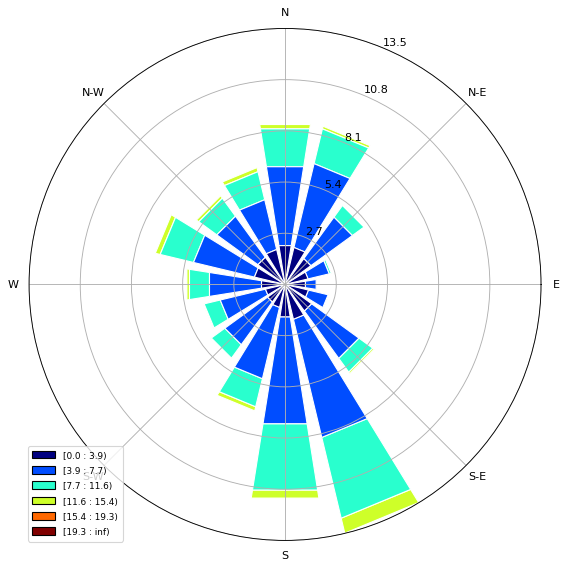

In [21]:
from windrose import WindroseAxes
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
ax = WindroseAxes.from_ax(theta_labels=new_labels)
ax.bar(direction1D, speed1D, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

In [22]:
# filter for speed and direction when it is a jet night
speed_jetnight = np.array(speed[jethour_true,...]).reshape(-1,1).ravel()
direction_jetnight = np.array(direction[jethour_true,...]).reshape(-1,1).ravel()

# filter for speed and direction when it is not a jet night
speed_nonjetnight = np.array(speed[jethour_false,...]).reshape(-1,1).ravel()
direction_nonjetnight = np.array(direction[jethour_false,...]).reshape(-1,1).ravel()

Text(0.5, 1.0, 'Wind rose on jet nights (focused around -37°S, 144-145°E)')

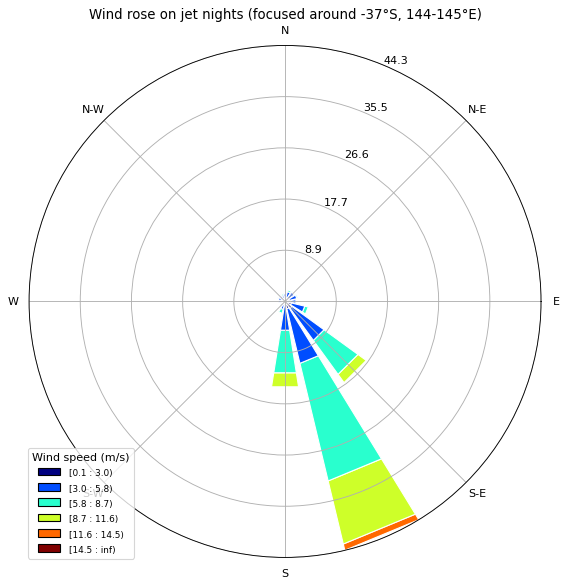

In [23]:
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
ax = WindroseAxes.from_ax(theta_labels=new_labels)
ax.bar(direction_jetnight, speed_jetnight, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title = 'Wind speed (m/s)')
ax.set_title('Wind rose on jet nights (focused around -37\N{DEGREE SIGN}S, 144-145\N{DEGREE SIGN}E)')

Text(0.5, 1.0, 'Wind rose on non jet nights (focused around -37°S, 144-145°E)')

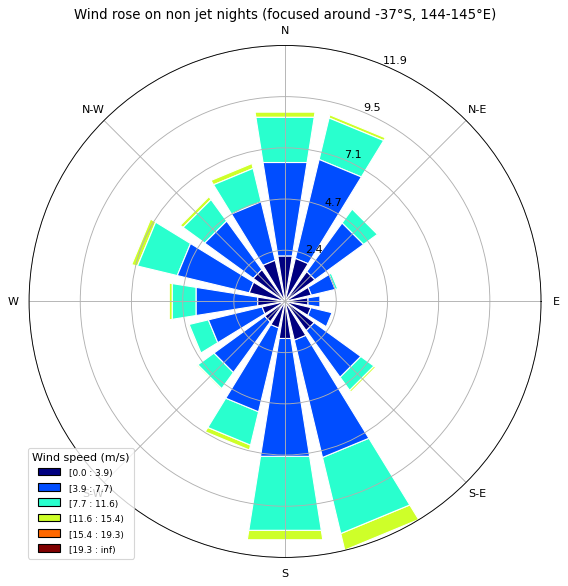

In [24]:
new_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
ax = WindroseAxes.from_ax(theta_labels=new_labels)
ax.bar(direction_nonjetnight, speed_nonjetnight, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title = 'Wind speed (m/s)')
ax.set_title('Wind rose on non jet nights (focused around -37\N{DEGREE SIGN}S, 144-145\N{DEGREE SIGN}E)')